Data from [An integrated single-cell reference atlas of the human endometrium](https://doi.org/10.1038/s41588-024-01873-w)

In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets
from importlib import resources


import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER}/menstrual_cycle/endometriumAtlasV2_nuclei.h5ad"
)

In [49]:
# divide by 3 the adata size
adata = adata[adata.obs.sample(frac=0.3).index]

In [50]:
adata.layers["total"] = np.rint(
    (np.exp(adata.X.toarray()) - 1)
    * adata.obs["n_counts"].to_numpy().reshape(-1, 1)
    / 10000
)

/tmp/ipykernel_1237458/2710025678.py:1: ImplicitModificationWarning: Setting element `.layers['total']` of view, initializing view as actual.
  adata.layers["total"] = np.rint(


In [53]:
g = utils.get_variable_genes(adata, 2000, layer="total")
len(g)

2000

In [56]:
SMALL_CYCLING_GENE_SET = np.array(
    list(
        set([g.upper() for g in gene_sets.SMALL_CELL_CYCLE_GENE_SET])
        & set(adata.var_names)
    )
)

In [57]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
    n_latent=10,
    n_harm=3,
    use_mu_z_encoder=True,
    use_amp_Z=True,
    z_range=20,
    rhythmic_z_scale=2,
    lambda_range=1,
)  # , categorical_covariate_dims=[27])
model.load_anndata(
    adata, layer_to_use="total"
)  # , batch_name="cancer_type")#,categorical_covariates=["group"])

In [ ]:
import torch

f_coeffs_path = (
    resources.files("CoPhaser") / "ressources" / "fourier_coefficients_RPE.csv"
)
f_coeffs = pd.read_csv(f_coeffs_path, index_col=0)
f_coeffs.drop("A_0", axis=1, inplace=True)
f_coeffs = f_coeffs.loc[model.rhythmic_gene_names].copy()
old_weights = model.rhythmic_decoder.fourier_coefficients.weight.detach().clone()
old_weights[model.rhythmic_gene_indices, :] = torch.tensor(f_coeffs.values).float()
old_weights = torch.nn.Parameter(old_weights)
model.rhythmic_decoder.fourier_coefficients.weight = old_weights
model.rhythmic_decoder.freeze_weights_genes(model.rhythmic_gene_indices)

Epoch 1/200, elbo_loss: 6541.9414, kl_div_f: 4.6778, kl_div_z: 32.8609, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.0807, entropy_loss: -308.0698, radial_variance: 5.4427, radius: 8.0158, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 6247.3301
Epoch 2/200, elbo_loss: 5185.0413, kl_div_f: 4.6202, kl_div_z: 37.0756, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.9509, entropy_loss: -295.0853, radial_variance: 4.2924, radius: 4.3877, L1_mu_z: 0.0000, MI_loss: 0.0002, total_loss: 4898.6553
Epoch 3/200, elbo_loss: 4921.7757, kl_div_f: 4.5636, kl_div_z: 37.4915, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.1422, entropy_loss: -314.2166, radial_variance: 2.0206, radius: 3.2646, L1_mu_z: 0.0000, MI_loss: 0.0018, total_loss: 4613.0286
Epoch 4/200, elbo_loss: 4780.1123, kl_div_f: 4.5027, kl_div_z: 37.6614, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2667, en

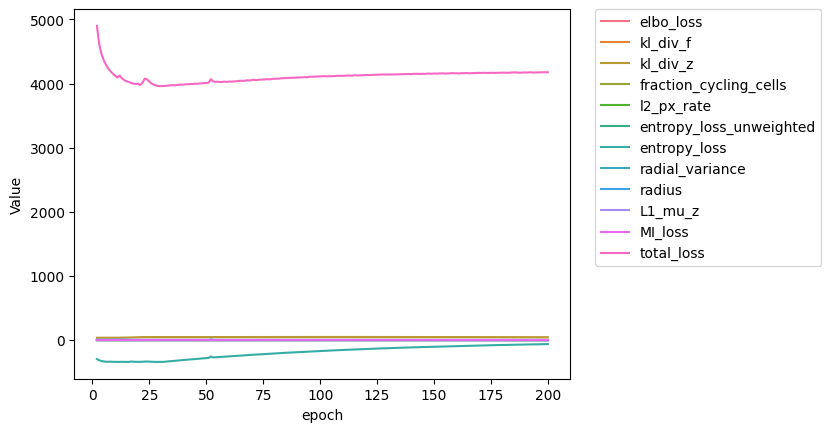

In [ ]:
trainer = Trainer(
    model,
    Loss.compute_loss,
    calculate_entropy_per_batch=False,
    L2_Z_decoder_loss_weight=0,
    entropy_weight_factor=100,
    closed_circle_weight=10,
    MI_weight=100,
    cycling_status_prior=0.1,
    beta_kl_cycling_status=20,
    unfreeze_epoch_layer=[(20, "rhythmic_decoder")],
    rhythmic_likelihood_weight=20,
    non_rhythmic_likelihood_weight=5,
)  # , entropy_weight_factor=5)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=8192,
)

<Axes: ylabel='Count'>

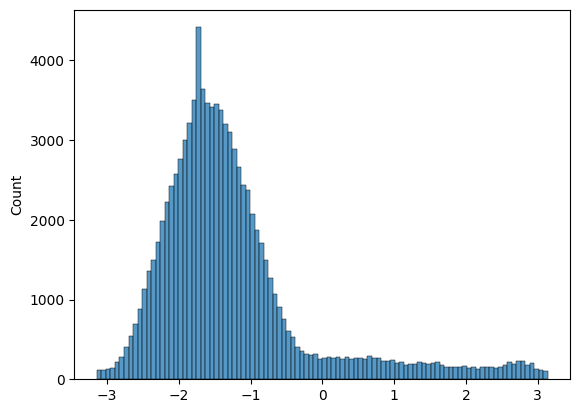

In [60]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(thetas, bins=100)

In [61]:
cycling_cells = space_outputs["b_z"].detach().numpy() > 0.5

<Axes: ylabel='Count'>

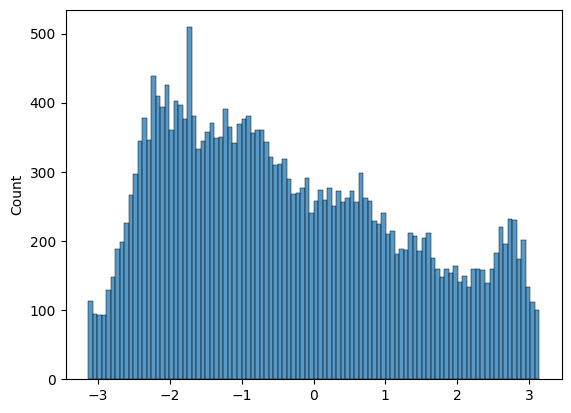

In [62]:
sns.histplot(thetas[cycling_cells], bins=100)

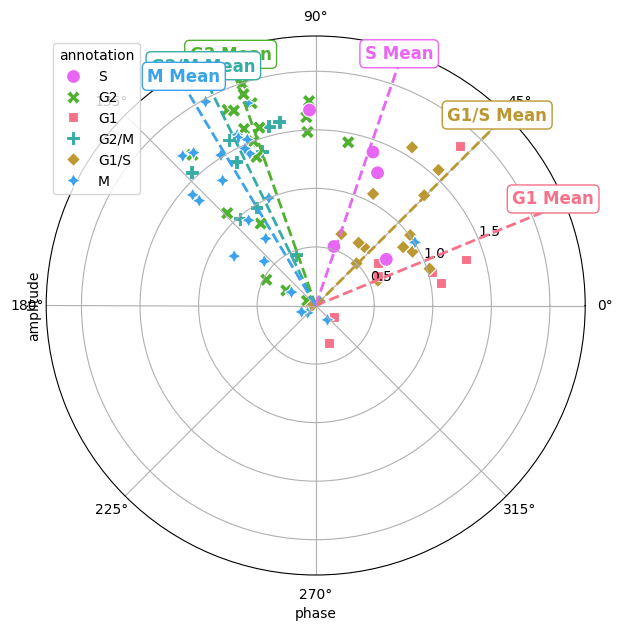

In [63]:
thetas = model.infer_pseudotimes(adata, "total")

In [67]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions

In [68]:
cycling_cells

array([False,  True, False, ...,  True, False, False])

<Axes: >

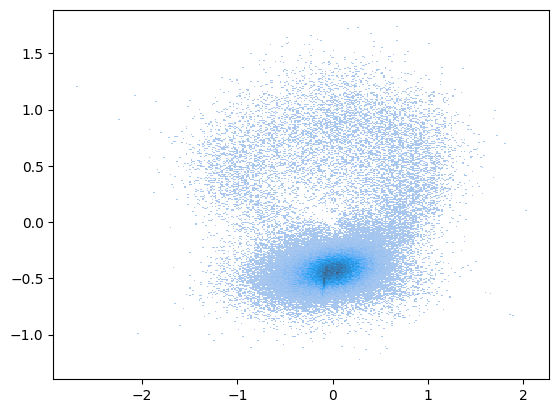

In [70]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

<Axes: >

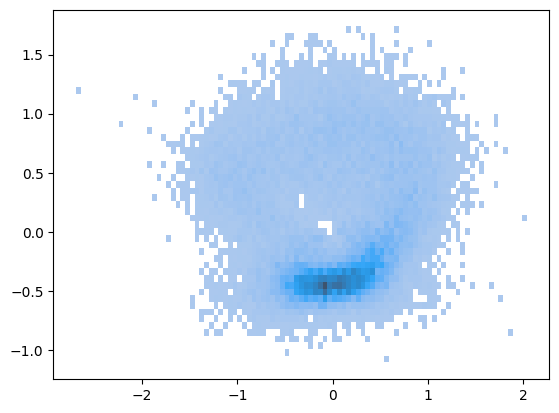

In [71]:
sns.histplot(x=cells_projected[cycling_cells, 0], y=cells_projected[cycling_cells, 1])

<Axes: xlabel='None', ylabel='Count'>

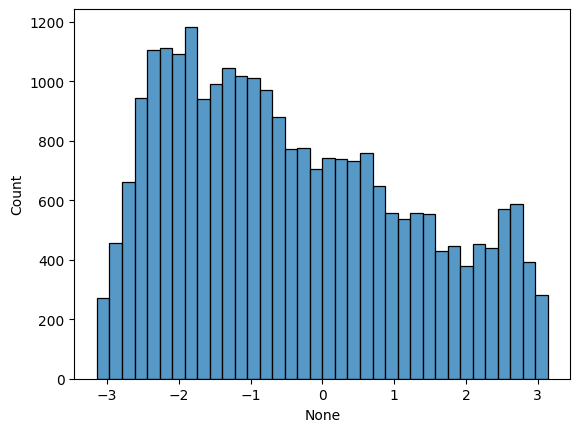

In [72]:
sns.histplot(x=thetas[cycling_cells])

In [73]:
# index=adata.obs[(adata.obs["inferred_theta"]<-2)|(adata.obs["inferred_theta"]>-1)].index
# index.append(adata.obs[(adata.obs["inferred_theta"]>-2)&(adata.obs["inferred_theta"]<-1)].sample(frac=0.3).index)

In [74]:
# adata=adata[index]

<Axes: xlabel='None', ylabel='Count'>

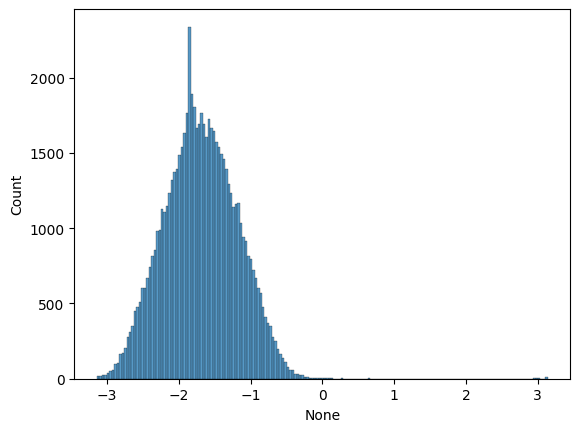

In [75]:
sns.histplot(x=thetas[~cycling_cells])

In [76]:
df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)

In [77]:
import umap

embedding = umap.UMAP().fit_transform(space_outputs["z"].detach().numpy())

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [78]:
thetas

tensor([-2.1814,  2.4023, -1.9022,  ..., -0.1370, -1.2683, -2.1014])

/tmp/ipykernel_1237458/2035800140.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proliferating.groupby(["cell_type", "patient_id"])["proliferating_status"]
/tmp/ipykernel_1237458/2035800140.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for subtype, df in patient_means.groupby("cell_type")
/tmp/ipykernel_1237458/2035800140.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_means.groupby(["cell_ty

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Cycling'),
  Text(1, 0, '\neStromal_cycling'),
  Text(2, 0, 'ePV_1b'),
  Text(3, 0, '\npreCiliated'),
  Text(4, 0, 'SOX9_luminal'),
  Text(5, 0, '\npreLuminal'),
  Text(6, 0, 'Immune_Lymphoid'),
  Text(7, 0, '\nImmune_Myeloid'),
  Text(8, 0, 'Ciliated'),
  Text(9, 0, '\nLymphatic'),
  Text(10, 0, 'Arterial'),
  Text(11, 0, '\nGlandular_secretory'),
  Text(12, 0, 'Luminal'),
  Text(13, 0, '\nVenous')])

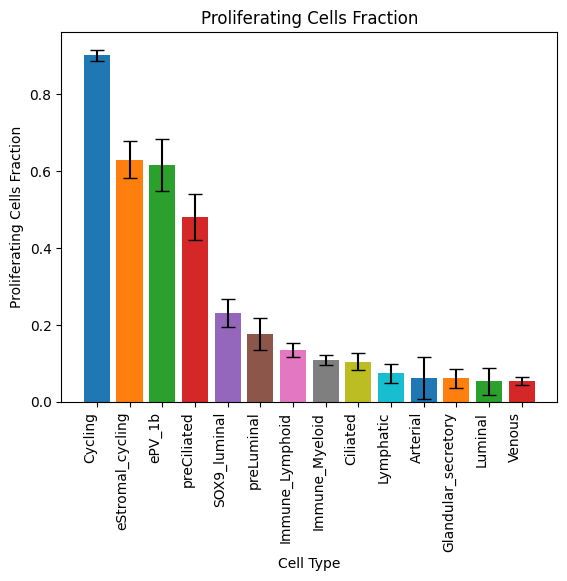

In [79]:
proliferating_cells = (cycling_cells) & (thetas.detach().numpy() > 0)
df_proliferating = pd.DataFrame(
    {
        "proliferating_status": proliferating_cells,
        "cell_type": adata.obs["celltype"].values,
        "patient_id": adata.obs["genotype"].values,
        "binary_stage": adata.obs["Binary Stage"].values,
    }
)

# Compute patient-level means
patient_means = (
    df_proliferating.groupby(["cell_type", "patient_id"])["proliferating_status"]
    .mean()
    .reset_index()
)

# Organize values per subtype
subtype_groups = {
    subtype: df["proliferating_status"].values
    for subtype, df in patient_means.groupby("cell_type")
}

# Now compute mean + SEM across patients within each subtype
summary = (
    patient_means.groupby(["cell_type", "patient_id"])["proliferating_status"]
    .mean()
    .groupby("cell_type")
    .agg(mean="mean", sem="sem")
    .reset_index()
)

# Barplot with SEM
ax = plt.gca()
# sort summary by mean descending
summary = summary.sort_values(by="mean", ascending=False).head(14)
summary = summary.drop(summary[summary["cell_type"] == "Unknown"].index)
ax.bar(
    [i % 2 * "\n" + str(name) for i, name in enumerate(summary["cell_type"])],
    summary["mean"],
    yerr=summary["sem"],
    capsize=5,
    color=sns.color_palette("tab10", n_colors=len(summary)),
)

ax.set_ylabel("Proliferating Cells Fraction")
ax.set_xlabel("Cell Type")
ax.set_title("Proliferating Cells Fraction")
# rotate x labels
plt.xticks(rotation=90, ha="right")

/tmp/ipykernel_1237458/358806473.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proliferating.groupby(["cell_type", "patient_id"])["proliferating_status"]
/tmp/ipykernel_1237458/358806473.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for subtype, df in patient_means.groupby("cell_type")
/tmp/ipykernel_1237458/358806473.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_means.groupby(["cell_type"

([0, 1, 2, 3],
 [Text(0, 0, 'Proliferative'),
  Text(1, 0, '\nSecretory'),
  Text(2, 0, 'Hormones'),
  Text(3, 0, '\nMenstrual')])

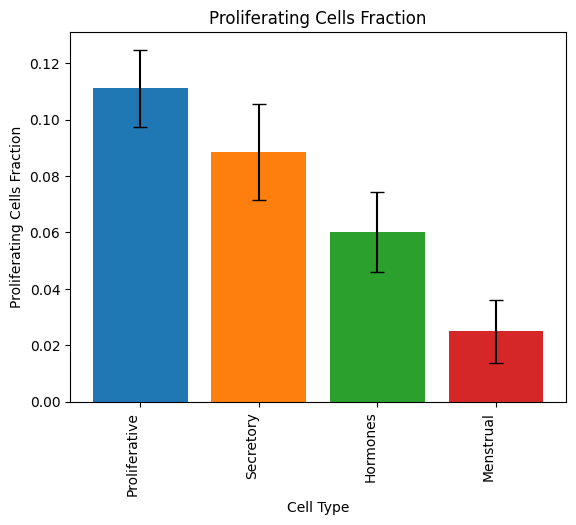

In [81]:
proliferating_cells = (cycling_cells) & (thetas.detach().numpy() > 0)
df_proliferating = pd.DataFrame(
    {
        "proliferating_status": proliferating_cells,
        "cell_type": adata.obs["Binary Stage"].values,
        "patient_id": adata.obs["genotype"].values,
    }
)

# Compute patient-level means
patient_means = (
    df_proliferating.groupby(["cell_type", "patient_id"])["proliferating_status"]
    .mean()
    .reset_index()
)

# Organize values per subtype
subtype_groups = {
    subtype: df["proliferating_status"].values
    for subtype, df in patient_means.groupby("cell_type")
}

# Now compute mean + SEM across patients within each subtype
summary = (
    patient_means.groupby(["cell_type", "patient_id"])["proliferating_status"]
    .mean()
    .groupby("cell_type")
    .agg(mean="mean", sem="sem")
    .reset_index()
)

# Barplot with SEM
ax = plt.gca()
# sort summary by mean descending
summary = summary.sort_values(by="mean", ascending=False).head(14)
summary = summary.drop(summary[summary["cell_type"] == "Unknown"].index)
ax.bar(
    [i % 2 * "\n" + str(name) for i, name in enumerate(summary["cell_type"])],
    summary["mean"],
    yerr=summary["sem"],
    capsize=5,
    color=sns.color_palette("tab10", n_colors=len(summary)),
)

ax.set_ylabel("Proliferating Cells Fraction")
ax.set_xlabel("Cell Type")
ax.set_title("Proliferating Cells Fraction")
# rotate x labels
plt.xticks(rotation=90, ha="right")

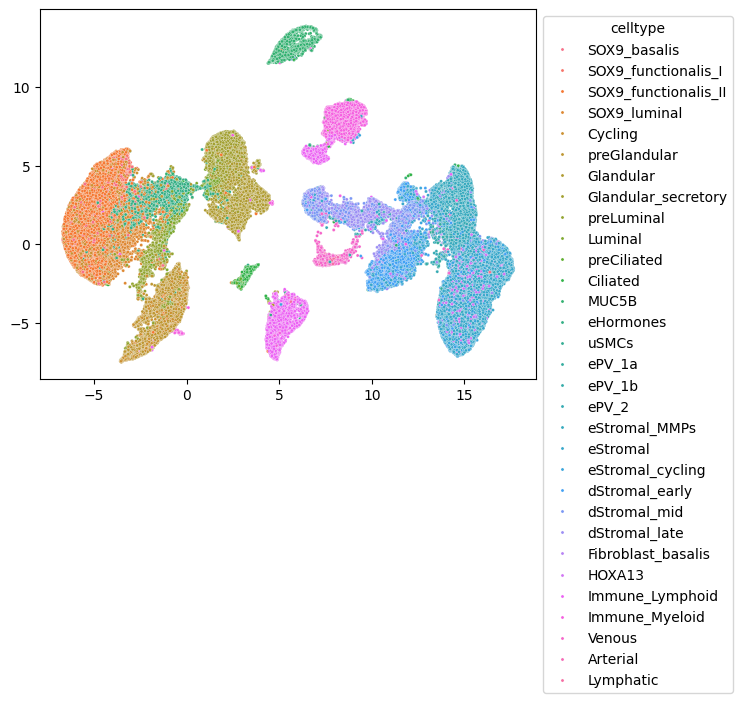

In [82]:
ax = sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], hue=adata.obs["celltype"], s=5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

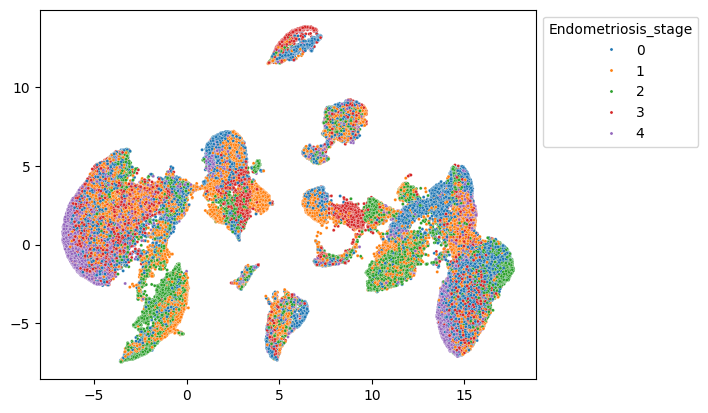

In [83]:
ax = sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], hue=adata.obs["Endometriosis_stage"], s=5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [85]:
df_rhythmic["inferred_theta"] = thetas

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:492: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


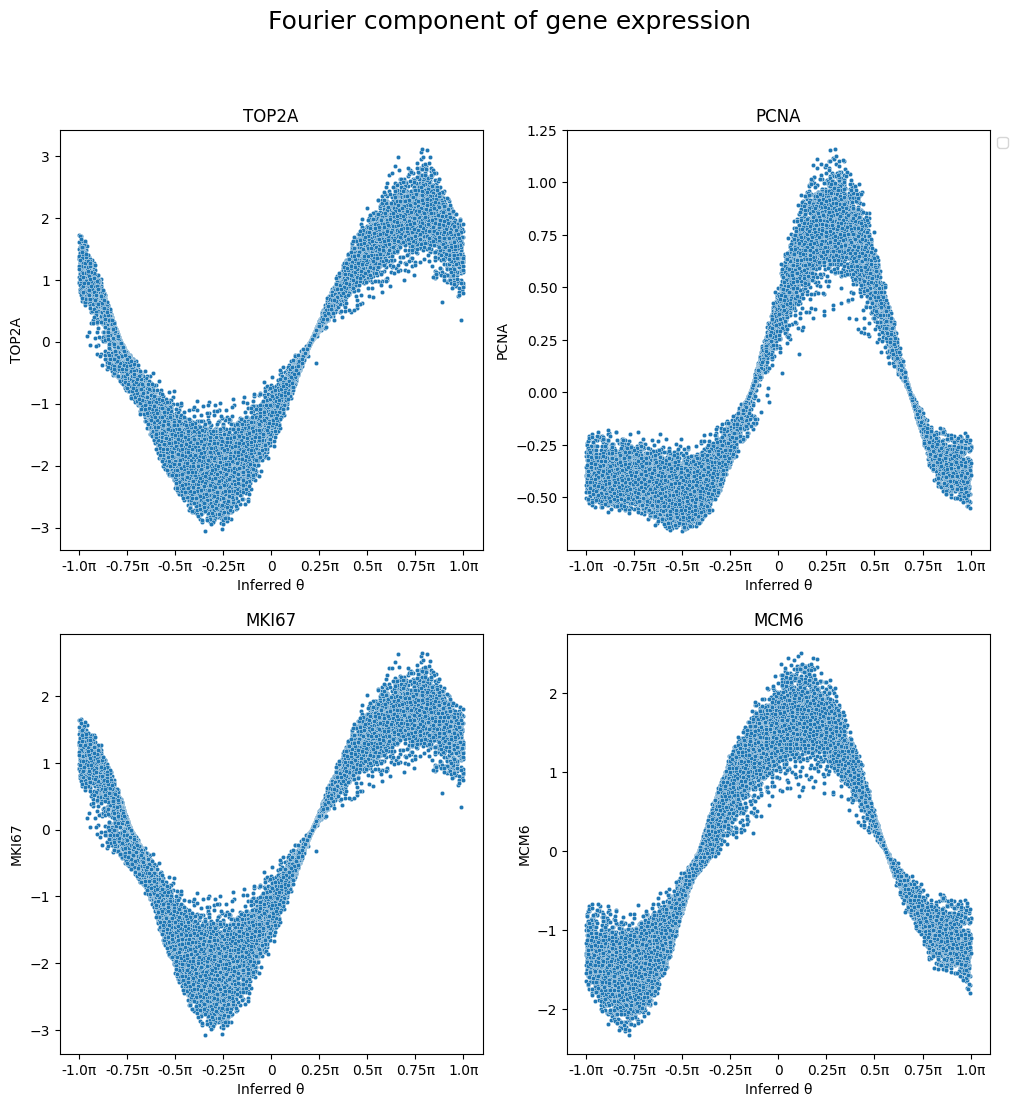

In [86]:
plotting.plot_model_decoded_space(
    df_rhythmic.loc[cycling_cells],
    gene_to_upper=True,
    title="Fourier component of gene expression",
)

In [ ]:
# # # to save
# to_save = {
#     "thetas": thetas,
#     "adata": adata,
#     "cycling_cells": cycling_cells,
#     "df_f": df_rhythmic,
#     "df_z": df_z,
#     "df_mean": df_mean,
#     "z_space": embedding,
# }
# import pickle

# with open("data/cell_cycle_results.pkl", "wb") as f:
#     pickle.dump(to_save, f)